In [1]:
import os
import yaml
import pickle
import numpy as np
import pandas as pd
import itertools
import scipy
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt

from produce_dataset import *

In [2]:
df_econ = loadEconData('/ecoderemdvol/EleGun/EPGun-PU200/data/econ_ntuples/0002/',
                       'FloatingpointAutoEncoderEMDAEMSEttbarDummyHistomaxGenmatchGenclustersntuple',
                       'econ2_data.csv')
df_gen = loadGenData('/ecoderemdvol/EleGun/EPGun-PU200/data/econ_ntuples/0002/',
                       'FloatingpointAutoEncoderEMDAEMSEttbarDummyHistomaxGenmatchGenclustersntuple',
                       'gen2_data.csv')

In [3]:
#Only wafers w/ simenergy
df_econ

,ECON_0,ECON_1,ECON_2,ECON_3,ECON_4,ECON_5,ECON_6,ECON_7,ECON_8,ECON_9,...,ECON_14,ECON_15,subdet,zside,layer,waferu,waferv,wafer_energy,tc_eta,tc_phi
0,0,64,64,128,192,0,64,64,64,0,...,128,128,2,-1,34,0,-4,0.074288,2.372685,-2.040177
1,0,192,64,128,128,0,128,128,64,128,...,128,64,2,-1,33,1,2,0.054336,2.995116,1.568720
2,0,64,64,0,192,0,0,64,64,64,...,192,192,2,-1,32,3,5,0.062769,2.518934,1.704076
3,0,128,64,64,128,0,128,128,192,128,...,64,128,2,-1,32,3,4,0.052978,2.725063,1.900426
4,0,192,256,64,64,0,64,192,192,64,...,64,64,2,-1,32,2,-3,0.199256,2.315148,-2.414000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,0,192,64,128,64,0,192,0,64,0,...,64,192,2,1,31,7,-1,0.045764,1.810699,-2.057722
1383,0,128,64,192,128,0,64,64,128,64,...,64,64,2,1,32,4,3,0.056133,2.679591,2.467138
1384,0,128,128,256,128,0,128,0,128,128,...,128,64,2,1,33,4,5,0.101164,2.222633,1.873401
1385,0,64,64,64,128,0,128,64,64,128,...,64,128,2,1,34,-2,1,0.030041,2.960287,0.120638


In [4]:
df_gen

,pt,energy,eta,phi
0,80.423019,522.664307,2.558814,-1.537044
1,80.423019,522.664307,-2.558814,1.604549
2,124.385948,865.018127,2.627299,2.385952
3,124.385948,865.018127,-2.627299,-0.755641
4,52.817207,139.043152,1.622896,-1.908449
5,52.817207,139.043152,-1.622896,1.233144
6,33.214794,90.601547,1.661191,-2.387945
7,33.214794,90.601547,-1.661191,0.753648
8,190.976349,941.367493,2.277879,2.054649
9,190.976349,941.367493,-2.277879,-1.086944


In [5]:
df_nodes=df_econ[['ECON_0', 'ECON_1', 'ECON_2', 'ECON_3', 'ECON_4', 'ECON_5', 'ECON_6',
       'ECON_7', 'ECON_8', 'ECON_9', 'ECON_10', 'ECON_11', 'ECON_12','ECON_13', 'ECON_14', 'ECON_15', 
        'wafer_energy', 'tc_eta', 'tc_phi']]

In [6]:
embeddings = torch.tensor(df_nodes.values)

In [7]:
eta=df_nodes['tc_eta']
phi=df_nodes['tc_phi']
idx = range(len(eta))
indices_i = np.array([i for i,j in itertools.product(idx,idx)])
indices_j = np.array([j for i,j in itertools.product(idx,idx)])

In [8]:
del_R = np.empty([len(eta),len(eta)])

In [9]:
for (i, j) in zip(indices_i,indices_j):
    del_R[i][j]=np.sqrt((eta[i]-eta[j])**2+((phi[i]-phi[j])%2*np.pi)**2)

In [10]:
del_R = torch.tensor(del_R)

In [11]:
del_R

tensor([[0.0000, 1.3773, 0.8167,  ..., 0.3102, 5.8078, 5.2635],
        [5.0927, 0.0000, 5.8773,  ..., 5.3817, 4.5494, 4.1059],
        [5.4817, 0.6384, 0.0000,  ..., 5.7589, 4.9941, 4.4677],
        ...,
        [6.0136, 1.2300, 0.6089,  ..., 0.0000, 5.5557, 4.9899],
        [0.7749, 1.7343, 1.3811,  ..., 1.0712, 0.0000, 5.8135],
        [1.0326, 2.3791, 1.8490,  ..., 1.2933, 0.9000, 0.0000]],
       dtype=torch.float64)

In [12]:
adj = np.zeros([len(eta),len(eta)])
for (i, j) in zip(indices_i,indices_j):
    if del_R[i][j] <0.025 and  del_R[i][j]> 0 :
        adj[i][j]=1
adj=torch.tensor(adj)       

In [13]:
edge_index = (adj > 0).nonzero().t()
edge_index.shape

torch.Size([2, 2461])

In [14]:
ys = torch.tensor(df_nodes['wafer_energy'])

In [15]:
graph = data.Data(x=embeddings, edge_index=edge_index, y=ys)

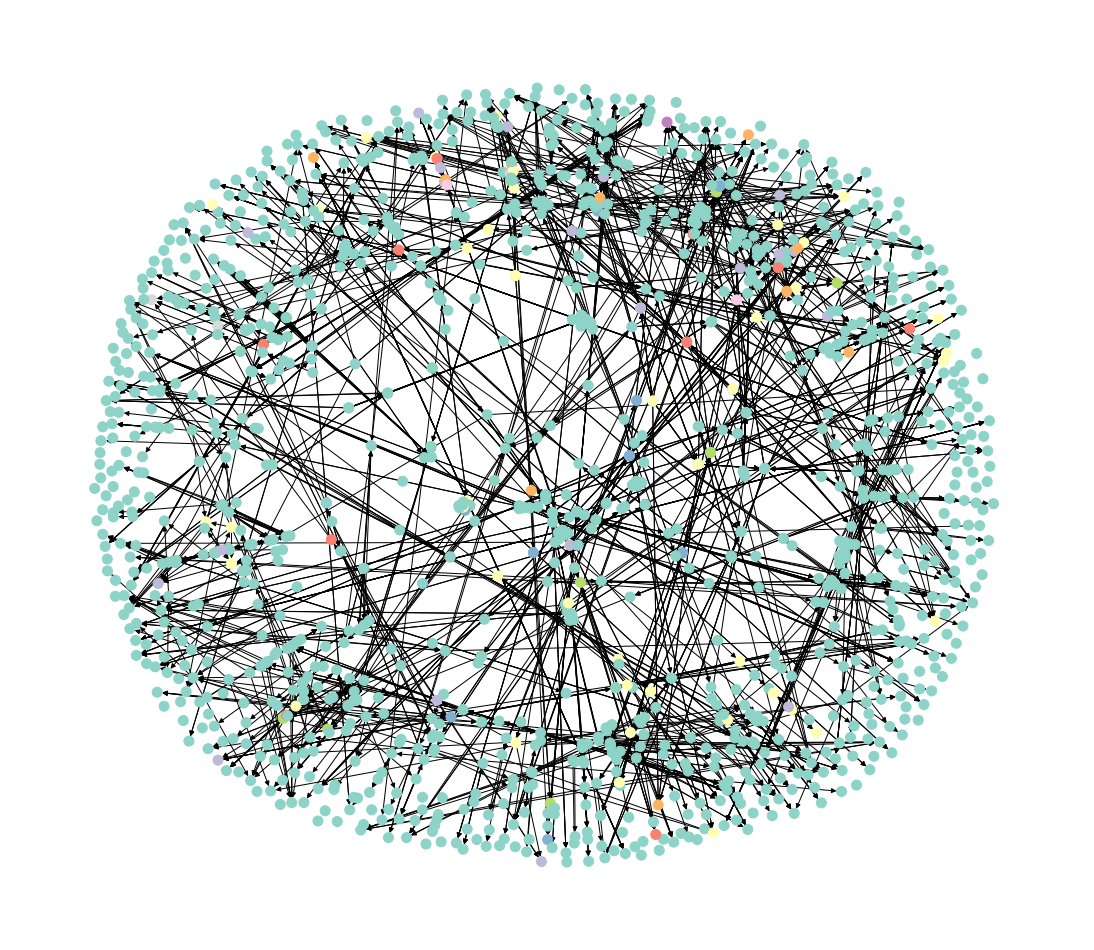

In [16]:
vis = to_networkx(graph)
#color per wafer_energy, could also make this sum of econ_charges
node_labels = graph.y.numpy()
plt.figure(1,figsize=(15,13)) 
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_color =node_labels,node_size=100,linewidths=1)
plt.show()

Text(0.5, 1.0, 'Event w/o PU')

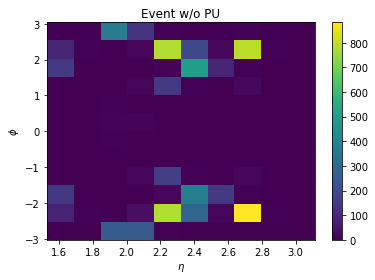

In [17]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()
h = ax.hist2d(x=eta,y=phi,bins=(10,12),weights=df_nodes['wafer_energy'])
fig.colorbar(h[3], ax=ax)
plt.xlabel(r'$\eta$');
plt.ylabel(r'$\phi$');
plt.title('Event w/o PU')